In [1]:
import scipy.io
import numpy as np
import os
import random
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
from collections import Counter

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("Libraries imported successfully.")

# --- Define Full, Explicit Dataset Paths ---
# E8 Paths (for Training)
E8_UNINFECTED_PATH = 'data/TME204-Patch_E4_E6_E8_28DPI_Dataset/E8-TME204/E8_TME204_28dpi_Dec_16_2020/Uninfected/E8_TME204_28dpi_Dec_16_2020_Uninfected_11_06_23_33.mat'
E8_UCBSV_PATH = 'data/TME204-Patch_E4_E6_E8_28DPI_Dataset/E8-TME204/E8_TME204_28dpi_Dec_16_2020/UCBSV/E8_TME204_28dpi_Dec_16_2020_UCBSV_11_06_23_36.mat'

# E4 Paths (for External Testing)
E4_UNINFECTED_PATH = 'data/TME204-Patch_E4_E6_E8_28DPI_Dataset/E4-TME204/E4_TME204_28dpi_Mar_5_2020/Uninfected/E4_TME204_28dpi_Mar_5_2020_Uninfected_11_06_23_18.mat'
E4_UCBSV_PATH = 'data/TME204-Patch_E4_E6_E8_28DPI_Dataset/E4-TME204/E4_TME204_28dpi_Mar_5_2020/UCBSV/E4_TME204_28dpi_Mar_5_2020_UCBSV_11_06_23_21.mat'

print("File paths defined.")

def load_scans_from_mat(file_path):
    """
    Loads all scans from a .mat file, returning a list of patch arrays.
    """
    mat_data = scipy.io.loadmat(file_path, squeeze_me=True)
    all_scans_struct = mat_data['Patch']
    
    if all_scans_struct.ndim == 0:
        all_scans_struct = np.array([all_scans_struct])
        
    scans_data = []
    for scan_struct in all_scans_struct:
        mean_vals = scan_struct['mean_values']
        if mean_vals.ndim == 0:
            scans_data.append(mean_vals.item())
        else:
            scans_data.append(mean_vals)
            
    return scans_data

print("Data loading function defined.")

# --- Configuration ---
N_REPEATS = 100
PARAM_GRID = {'C': [1, 10, 100], 'gamma': [0.01, 0.1, 1], 'kernel': ['rbf']}
CV_FOLDS = 20

# --- Data Loading (once at the beginning) ---
# Training Data (E8)
e8_uninfected_scans = load_scans_from_mat(E8_UNINFECTED_PATH)
e8_ucbsv_scans = load_scans_from_mat(E8_UCBSV_PATH)
print(f"Loaded E8 data: {len(e8_uninfected_scans)} uninfected scans, {len(e8_ucbsv_scans)} infected scans.")

# External Test Data (E4)
e4_uninfected_scans = load_scans_from_mat(E4_UNINFECTED_PATH)
e4_ucbsv_scans = load_scans_from_mat(E4_UCBSV_PATH)
print(f"Loaded E4 data: {len(e4_uninfected_scans)} uninfected scans, {len(e4_ucbsv_scans)} infected scans.")


# --- Prepare the full E4 test set (patches and true scan-level labels) ---
# This remains the same for all repeats
X_test_e4_patches = np.concatenate(e4_uninfected_scans + e4_ucbsv_scans)
# True labels at the SCAN level for E4
y_true_e4_scans = np.concatenate([
    np.full(len(e4_uninfected_scans), 0), # 0 for uninfected
    np.full(len(e4_ucbsv_scans), 1)       # 1 for infected
])


# --- Result Storage ---
e8_holdout_accuracies = []
e4_majority_vote_accuracies = []
best_params_list = []

print(f"\nStarting {N_REPEATS} iterations of the experiment (Train on E8, Test on E4)...")

# --- Main Loop ---
for i in range(N_REPEATS):
    print(f"--- Iteration {i + 1}/{N_REPEATS} ---")

    # 1. Split E8 data: Isolate 1 of each class for hold-out testing
    random.shuffle(e8_uninfected_scans)
    random.shuffle(e8_ucbsv_scans)
    
    e8_test_scans = [e8_uninfected_scans[0], e8_ucbsv_scans[0]]
    e8_train_val_scans = e8_uninfected_scans[1:] + e8_ucbsv_scans[1:]
    
    # 2. Prepare training/validation and E8-holdout sets (patch level)
    X_train_val = np.concatenate(e8_train_val_scans)
    y_train_val = np.concatenate([np.full(len(e8_uninfected_scans[1:]) * 9, 0), np.full(len(e8_ucbsv_scans[1:]) * 9, 1)])
    
    X_test_e8_patches = np.concatenate(e8_test_scans)
    y_test_e8_patches = np.concatenate([np.full(9, 0), np.full(9, 1)])

    # 3. Scale data: Fit ONLY on the E8 training/validation data
    scaler = StandardScaler().fit(X_train_val)
    X_train_val_scaled = scaler.transform(X_train_val)
    X_test_e8_scaled = scaler.transform(X_test_e8_patches)
    X_test_e4_scaled = scaler.transform(X_test_e4_patches)
    
    # 4. Hyperparameter tuning using GridSearchCV on the 34-scan E8 set
    cv_splitter = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=i)
    grid_search = GridSearchCV(SVC(), PARAM_GRID, cv=cv_splitter, n_jobs=-1)
    grid_search.fit(X_train_val_scaled, y_train_val)
    
    best_params = grid_search.best_params_
    best_params_list.append(best_params)
    
    # 5. Train the final model on the entire 34-scan E8 set with best parameters
    final_model = SVC(**best_params).fit(X_train_val_scaled, y_train_val)
    
    # 6. Test and record accuracies
    # a) Test on E8 hold-out set (patch-level accuracy)
    y_pred_e8 = final_model.predict(X_test_e8_scaled)
    e8_holdout_accuracies.append(accuracy_score(y_test_e8_patches, y_pred_e8))
    
    # b) Test on external E4 set using MAJORITY VOTING
    y_pred_e4_patches = final_model.predict(X_test_e4_scaled)
    
    y_pred_e4_scans = []
    current_patch_index = 0
    # Iterate through the original E4 scan groups to apply majority vote
    for scan_group in (e4_uninfected_scans, e4_ucbsv_scans):
        for scan in scan_group:
            num_patches = len(scan)
            # Get the predictions for the patches of the current scan
            scan_patch_preds = y_pred_e4_patches[current_patch_index : current_patch_index + num_patches]
            current_patch_index += num_patches
            
            # Perform majority voting
            vote_counts = Counter(scan_patch_preds)
            # Find the class with the most votes. .most_common(1) returns a list of [ (item, count) ]
            majority_vote = vote_counts.most_common(1)[0][0]
            y_pred_e4_scans.append(majority_vote)
            
    # Calculate accuracy at the scan level for E4
    e4_majority_vote_accuracies.append(accuracy_score(y_true_e4_scans, y_pred_e4_scans))


print("\n--- Experiment Complete ---")

# --- Analyze and Report Final Results ---
e8_holdout_accuracies = np.array(e8_holdout_accuracies)
e4_majority_vote_accuracies = np.array(e4_majority_vote_accuracies)

# E8 Hold-out Test Results
mean_e8 = np.mean(e8_holdout_accuracies)
std_e8 = np.std(e8_holdout_accuracies)
print("\n--- Test on E8 Hold-out Set (2 leaves, Patch-Level Accuracy) ---")
print(f"Method: In each of {N_REPEATS} iterations, 1 uninfected and 1 infected leaf from E8 were held out.")
print(f"The model was trained on the remaining 34 leaves from E8.")
print(f"Mean Accuracy: {mean_e8 * 100:.2f}%")
print(f"Standard Deviation: {std_e8 * 100:.2f}%")
print("-" * 60)

# E4 External Test Results (Majority Vote)
mean_e4 = np.mean(e4_majority_vote_accuracies)
std_e4 = np.std(e4_majority_vote_accuracies)
print("\n--- Test on External E4 Dataset (Scan-Level, Majority-Vote Accuracy) ---")
print(f"Method: The same {N_REPEATS} models trained on E8 were tested against the full, unseen E4 dataset.")
print("For each scan in E4, the class was predicted based on the majority vote of its 9 patches.")
print(f"Mean Scan-Level Accuracy: {mean_e4 * 100:.2f}%")
print(f"Standard Deviation: {std_e4 * 100:.2f}%")
print("-" * 60)

# Hyperparameter Analysis
print("\n--- Hyperparameter Selection Analysis ---")
params_df = pd.DataFrame(best_params_list)
# Corrected groupby as discussed in the analysis
param_counts = params_df.groupby(['C', 'gamma', 'kernel']).size().reset_index(name='counts')
print(f"Frequency of best parameters selected by GridSearchCV across {N_REPEATS} iterations:")
print(param_counts.sort_values(by='counts', ascending=False))

Libraries imported successfully.
File paths defined.
Data loading function defined.
Loaded E8 data: 18 uninfected scans, 18 infected scans.
Loaded E4 data: 24 uninfected scans, 12 infected scans.

Starting 100 iterations of the experiment (Train on E8, Test on E4)...
--- Iteration 1/100 ---
--- Iteration 2/100 ---
--- Iteration 3/100 ---
--- Iteration 4/100 ---
--- Iteration 5/100 ---
--- Iteration 6/100 ---
--- Iteration 7/100 ---
--- Iteration 8/100 ---
--- Iteration 9/100 ---
--- Iteration 10/100 ---
--- Iteration 11/100 ---
--- Iteration 12/100 ---
--- Iteration 13/100 ---
--- Iteration 14/100 ---
--- Iteration 15/100 ---
--- Iteration 16/100 ---
--- Iteration 17/100 ---
--- Iteration 18/100 ---
--- Iteration 19/100 ---
--- Iteration 20/100 ---
--- Iteration 21/100 ---
--- Iteration 22/100 ---
--- Iteration 23/100 ---
--- Iteration 24/100 ---
--- Iteration 25/100 ---
--- Iteration 26/100 ---
--- Iteration 27/100 ---
--- Iteration 28/100 ---
--- Iteration 29/100 ---
--- Iteration 30

# Experiment Summary

### Initialization
- **Libraries imported successfully.**
- **File paths defined.**
- **Data loading function defined.**

### Data Loaded
- **E8 Dataset:** 18 uninfected scans, 18 infected scans.
- **E4 Dataset:** 24 uninfected scans, 12 infected scans.

---

### Experiment: Train on E8, Test on E4
- **100 iterations of the experiment started...**

--- Iteration 1/100 --- --- Iteration 2/100 --- ... --- Iteration 100/100 ---


- **Experiment Complete.**

---

### Results

#### Test on E8 Hold-out Set (Patch-Level Accuracy)
- **Method:** In each of 100 iterations, 1 uninfected and 1 infected leaf from E8 were held out.  
  The model was trained on the remaining 34 leaves from E8.
- **Mean Accuracy:** 87.61%  
- **Standard Deviation:** 14.18%

---

#### Test on External E4 Dataset (Scan-Level, Majority-Vote Accuracy)
- **Method:** The same 100 models trained on E8 were tested against the full, unseen E4 dataset.  
  For each scan in E4, the class was predicted based on the majority vote of its 9 patches.
- **Mean Scan-Level Accuracy:** 33.25%  
- **Standard Deviation:** 0.47%

---

### Hyperparameter Selection Analysis
- **Frequency of best parameters selected by GridSearchCV across 100 iterations:**

|   C   | Gamma | Kernel | Counts |
|-------|-------|--------|--------|
|  100  | 0.01  |  rbf   |   97   |
|   10  | 0.10  |  rbf   |    3   |

--- Running a single iteration to generate a sample confusion matrix for E4 ---

--- Detailed Report for E4 Test Set (Single Run) ---
                      precision    recall  f1-score   support

Uninfected (Class 0)       0.00      0.00      0.00        24
  Infected (Class 1)       0.33      1.00      0.50        12

            accuracy                           0.33        36
           macro avg       0.17      0.50      0.25        36
        weighted avg       0.11      0.33      0.17        36



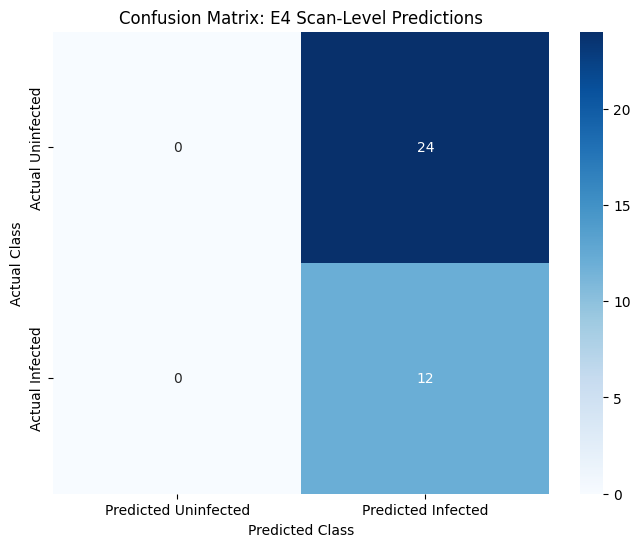

In [2]:
# CODE CELL FOR ANALYSIS (Add to your E8 -> E4 Notebook)

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# --- This block re-runs the first iteration to get a sample confusion matrix ---
print("--- Running a single iteration to generate a sample confusion matrix for E4 ---")

# 1. Shuffle and Split E8 data
random.shuffle(e8_uninfected_scans)
random.shuffle(e8_ucbsv_scans)
e8_test_scans = [e8_uninfected_scans[0], e8_ucbsv_scans[0]]
e8_train_val_scans = e8_uninfected_scans[1:] + e8_ucbsv_scans[1:]

# 2. Prepare patch-level data
X_train_val = np.concatenate(e8_train_val_scans)
y_train_val = np.concatenate([np.full(len(e8_uninfected_scans[1:]) * 9, 0), np.full(len(e8_ucbsv_scans[1:]) * 9, 1)])

# 3. Scale data
scaler = StandardScaler().fit(X_train_val)
X_train_val_scaled = scaler.transform(X_train_val)
X_test_e4_scaled = scaler.transform(X_test_e4_patches)

# 4. Tune and Train the model
cv_splitter = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=42)
grid_search = GridSearchCV(SVC(probability=True), PARAM_GRID, cv=cv_splitter, n_jobs=-1)
grid_search.fit(X_train_val_scaled, y_train_val)
final_model = SVC(**grid_search.best_params_).fit(X_train_val_scaled, y_train_val)

# 5. Predict on E4 and get majority vote predictions
y_pred_e4_patches = final_model.predict(X_test_e4_scaled)
y_pred_e4_scans = []
current_patch_index = 0
for scan_group in (e4_uninfected_scans, e4_ucbsv_scans):
    for scan in scan_group:
        num_patches = len(scan)
        scan_patch_preds = y_pred_e4_patches[current_patch_index : current_patch_index + num_patches]
        current_patch_index += num_patches
        majority_vote = Counter(scan_patch_preds).most_common(1)[0][0]
        y_pred_e4_scans.append(majority_vote)

# --- Generate and Print the Report and Matrix ---
print("\n--- Detailed Report for E4 Test Set (Single Run) ---")
# y_true_e4_scans was defined in your original script
# Class 0 = Uninfected, Class 1 = Infected
print(classification_report(y_true_e4_scans, y_pred_e4_scans, target_names=['Uninfected (Class 0)', 'Infected (Class 1)']))

cm = confusion_matrix(y_true_e4_scans, y_pred_e4_scans)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Uninfected', 'Predicted Infected'],
            yticklabels=['Actual Uninfected', 'Actual Infected'])
plt.title('Confusion Matrix: E4 Scan-Level Predictions')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

In [3]:
# CODE CELL FOR REVERSE TRIAL (Train E4 -> Test E8)

import scipy.io
import numpy as np
import random
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
from collections import Counter

# Suppress warnings
warnings.filterwarnings('ignore')
print("Libraries imported.")

# --- Define Paths ---
E8_UNINFECTED_PATH = 'data/TME204-Patch_E4_E6_E8_28DPI_Dataset/E8-TME204/E8_TME204_28dpi_Dec_16_2020/Uninfected/E8_TME204_28dpi_Dec_16_2020_Uninfected_11_06_23_33.mat'
E8_UCBSV_PATH = 'data/TME204-Patch_E4_E6_E8_28DPI_Dataset/E8-TME204/E8_TME204_28dpi_Dec_16_2020/UCBSV/E8_TME204_28dpi_Dec_16_2020_UCBSV_11_06_23_36.mat'
E4_UNINFECTED_PATH = 'data/TME204-Patch_E4_E6_E8_28DPI_Dataset/E4-TME204/E4_TME204_28dpi_Mar_5_2020/Uninfected/E4_TME204_28dpi_Mar_5_2020_Uninfected_11_06_23_18.mat'
E4_UCBSV_PATH = 'data/TME204-Patch_E4_E6_E8_28DPI_Dataset/E4-TME204/E4_TME204_28dpi_Mar_5_2020/UCBSV/E4_TME204_28dpi_Mar_5_2020_UCBSV_11_06_23_21.mat'
print("File paths defined.")

# --- Data Loading Function ---
def load_scans_from_mat(file_path):
    mat_data = scipy.io.loadmat(file_path, squeeze_me=True)
    all_scans_struct = mat_data['Patch']
    if all_scans_struct.ndim == 0:
        all_scans_struct = np.array([all_scans_struct])
    scans_data = [s['mean_values'].item() if s['mean_values'].ndim == 0 else s['mean_values'] for s in all_scans_struct]
    return scans_data
print("Data loading function defined.")

# --- Configuration ---
N_REPEATS = 100
PARAM_GRID = {'C': [1, 10, 100], 'gamma': [0.01, 0.1, 1], 'kernel': ['rbf']}
CV_FOLDS = 11 # Using 11 folds for the 22-scan training set

# --- Data Loading ---
e4_uninfected_scans_full = load_scans_from_mat(E4_UNINFECTED_PATH) # 24 scans
e4_ucbsv_scans = load_scans_from_mat(E4_UCBSV_PATH) # 12 scans
e8_uninfected_scans = load_scans_from_mat(E8_UNINFECTED_PATH)
e8_ucbsv_scans = load_scans_from_mat(E8_UCBSV_PATH)
print(f"Loaded E4 data: {len(e4_uninfected_scans_full)} uninfected, {len(e4_ucbsv_scans)} infected.")
print(f"Loaded E8 data: {len(e8_uninfected_scans)} uninfected, {len(e8_ucbsv_scans)} infected.")


# --- Prepare the full E8 test set (for majority voting) ---
X_test_e8_patches = np.concatenate(e8_uninfected_scans + e8_ucbsv_scans)
y_true_e8_scans = np.concatenate([np.full(len(e8_uninfected_scans), 0), np.full(len(e8_ucbsv_scans), 1)])


# --- Result Storage ---
e4_holdout_accuracies = []
e8_majority_vote_accuracies = []
best_params_list = []

print(f"\nStarting {N_REPEATS} iterations of the experiment (Train on E4, Test on E8)...")

# --- Main Loop ---
for i in range(N_REPEATS):
    print(f"--- Iteration {i + 1}/{N_REPEATS} ---")

    # 1. Create a balanced E4 training pool for this iteration
    random.shuffle(e4_uninfected_scans_full)
    e4_uninfected_selected = e4_uninfected_scans_full[:12]
    
    # This is our balanced pool of 24 scans (12 of each class)
    e4_training_pool_uninfected = list(e4_uninfected_selected)
    e4_training_pool_infected = list(e4_ucbsv_scans)
    
    # 2. Split the balanced pool: 2 for hold-out, 22 for train/validation
    random.shuffle(e4_training_pool_uninfected)
    random.shuffle(e4_training_pool_infected)
    
    e4_test_scans = [e4_training_pool_uninfected[0], e4_training_pool_infected[0]]
    e4_train_val_scans = e4_training_pool_uninfected[1:] + e4_training_pool_infected[1:] # 22 scans total

    # 3. Prepare patch-level data for training and E4 hold-out
    X_train_val = np.concatenate(e4_train_val_scans)
    y_train_val = np.concatenate([np.full(11 * 9, 0), np.full(11 * 9, 1)]) # 11 scans of each class
    
    X_test_e4_patches = np.concatenate(e4_test_scans)
    y_test_e4_patches = np.concatenate([np.full(9, 0), np.full(9, 1)])

    # 4. Scale data: Fit ONLY on the E4 training/validation data
    scaler = StandardScaler().fit(X_train_val)
    X_train_val_scaled = scaler.transform(X_train_val)
    X_test_e4_scaled = scaler.transform(X_test_e4_patches)
    X_test_e8_scaled = scaler.transform(X_test_e8_patches) # Use the same scaler for the external set
    
    # 5. Hyperparameter tuning using GridSearchCV on the 22-scan E4 set
    cv_splitter = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=i)
    grid_search = GridSearchCV(SVC(), PARAM_GRID, cv=cv_splitter, n_jobs=-1)
    grid_search.fit(X_train_val_scaled, y_train_val)
    
    best_params = grid_search.best_params_
    best_params_list.append(best_params)
    
    # 6. Train the final model on the entire 22-scan set with best parameters
    final_model = SVC(**best_params).fit(X_train_val_scaled, y_train_val)
    
    # 7. Test and record accuracies
    # a) Test on E4 hold-out set (patch-level accuracy)
    y_pred_e4 = final_model.predict(X_test_e4_scaled)
    e4_holdout_accuracies.append(accuracy_score(y_test_e4_patches, y_pred_e4))
    
    # b) Test on external E8 set using MAJORITY VOTING
    y_pred_e8_patches = final_model.predict(X_test_e8_scaled)
    y_pred_e8_scans = []
    current_patch_index = 0
    for scan_group in (e8_uninfected_scans, e8_ucbsv_scans):
        for scan in scan_group:
            num_patches = len(scan)
            scan_patch_preds = y_pred_e8_patches[current_patch_index : current_patch_index + num_patches]
            current_patch_index += num_patches
            majority_vote = Counter(scan_patch_preds).most_common(1)[0][0]
            y_pred_e8_scans.append(majority_vote)
            
    e8_majority_vote_accuracies.append(accuracy_score(y_true_e8_scans, y_pred_e8_scans))


print("\n--- Experiment Complete ---")

# --- Analyze and Report Final Results ---
e4_holdout_accuracies = np.array(e4_holdout_accuracies)
e8_majority_vote_accuracies = np.array(e8_majority_vote_accuracies)

# E4 Hold-out Results
mean_e4 = np.mean(e4_holdout_accuracies)
std_e4 = np.std(e4_holdout_accuracies)
print("\n--- Test on E4 Hold-out Set (2 leaves, Patch-Level Accuracy) ---")
print(f"Mean Accuracy: {mean_e4 * 100:.2f}%")
print(f"Standard Deviation: {std_e4 * 100:.2f}%")
print("-" * 60)

# E8 External Test Results
mean_e8 = np.mean(e8_majority_vote_accuracies)
std_e8 = np.std(e8_majority_vote_accuracies)
print("\n--- Test on External E8 Dataset (Scan-Level, Majority-Vote Accuracy) ---")
print(f"Mean Scan-Level Accuracy: {mean_e8 * 100:.2f}%")
print(f"Standard Deviation: {std_e8 * 100:.2f}%")
print("-" * 60)

Libraries imported.
File paths defined.
Data loading function defined.
Loaded E4 data: 24 uninfected, 12 infected.
Loaded E8 data: 18 uninfected, 18 infected.

Starting 100 iterations of the experiment (Train on E4, Test on E8)...
--- Iteration 1/100 ---
--- Iteration 2/100 ---
--- Iteration 3/100 ---
--- Iteration 4/100 ---
--- Iteration 5/100 ---
--- Iteration 6/100 ---
--- Iteration 7/100 ---
--- Iteration 8/100 ---
--- Iteration 9/100 ---
--- Iteration 10/100 ---
--- Iteration 11/100 ---
--- Iteration 12/100 ---
--- Iteration 13/100 ---
--- Iteration 14/100 ---
--- Iteration 15/100 ---
--- Iteration 16/100 ---
--- Iteration 17/100 ---
--- Iteration 18/100 ---
--- Iteration 19/100 ---
--- Iteration 20/100 ---
--- Iteration 21/100 ---
--- Iteration 22/100 ---
--- Iteration 23/100 ---
--- Iteration 24/100 ---
--- Iteration 25/100 ---
--- Iteration 26/100 ---
--- Iteration 27/100 ---
--- Iteration 28/100 ---
--- Iteration 29/100 ---
--- Iteration 30/100 ---
--- Iteration 31/100 ---
---

Generating distribution plots for available spectral bands...


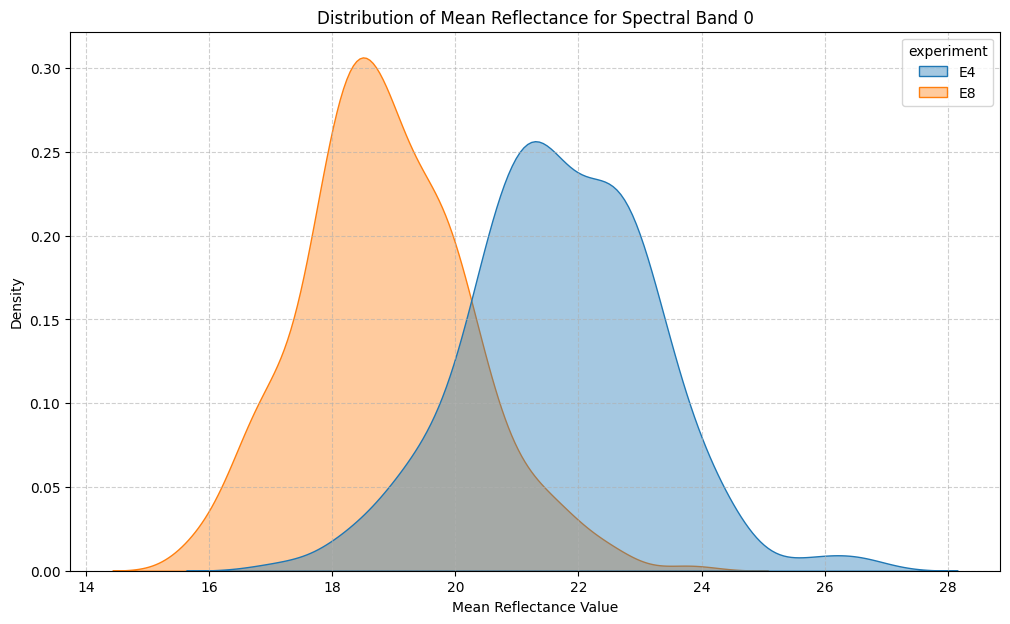

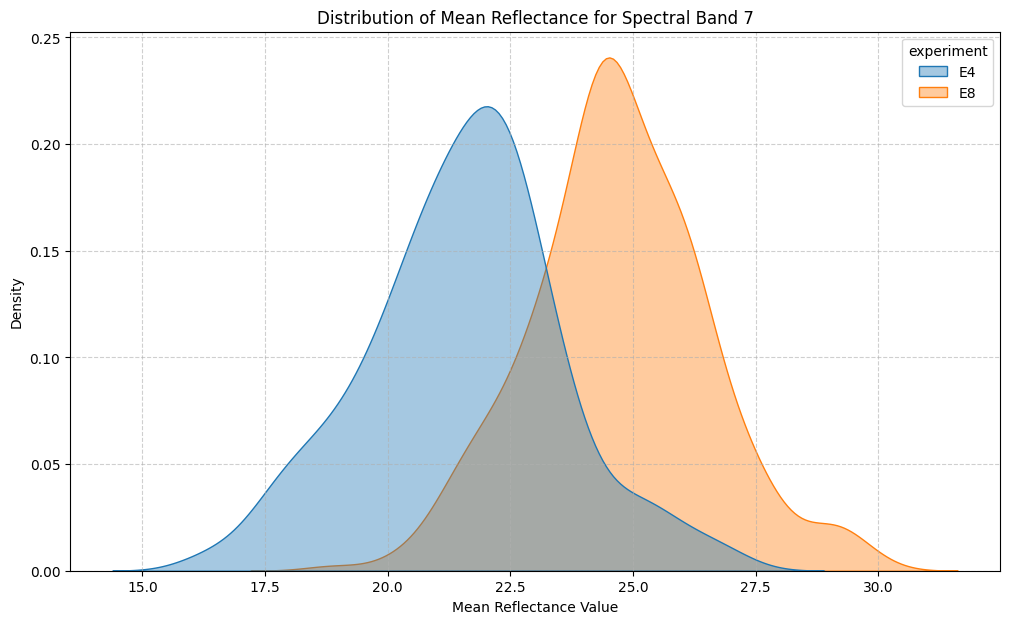

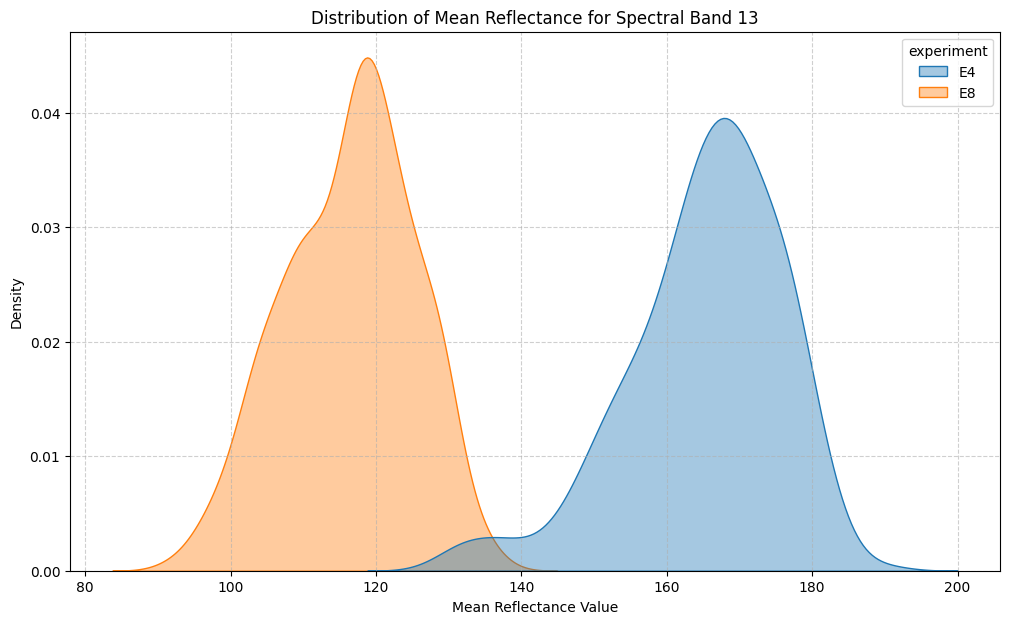

In [8]:
# FINAL WORKING CODE FOR VISUALIZING DATA SHIFT

import scipy.io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Define Paths ---
E8_UNINFECTED_PATH = 'data/TME204-Patch_E4_E6_E8_28DPI_Dataset/E8-TME204/E8_TME204_28dpi_Dec_16_2020/Uninfected/E8_TME204_28dpi_Dec_16_2020_Uninfected_11_06_23_33.mat'
E8_UCBSV_PATH = 'data/TME204-Patch_E4_E6_E8_28DPI_Dataset/E8-TME204/E8_TME204_28dpi_Dec_16_2020/UCBSV/E8_TME204_28dpi_Dec_16_2020_UCBSV_11_06_23_36.mat'
E4_UNINFECTED_PATH = 'data/TME204-Patch_E4_E6_E8_28DPI_Dataset/E4-TME204/E4_TME204_28dpi_Mar_5_2020/Uninfected/E4_TME204_28dpi_Mar_5_2020_Uninfected_11_06_23_18.mat'
E4_UCBSV_PATH = 'data/TME204-Patch_E4_E6_E8_28DPI_Dataset/E4-TME204/E4_TME204_28dpi_Mar_5_2020/UCBSV/E4_TME204_28dpi_Mar_5_2020_UCBSV_11_06_23_21.mat'

# --- Data Loading Function ---
def load_scans_from_mat(file_path):
    mat_data = scipy.io.loadmat(file_path, squeeze_me=True)
    all_scans_struct = mat_data['Patch']
    if all_scans_struct.ndim == 0:
        all_scans_struct = np.array([all_scans_struct])
    scans_data = [s['mean_values'].item() if s['mean_values'].ndim == 0 else s['mean_values'] for s in all_scans_struct]
    return scans_data

# --- Load all data ---
e4_un_patches = np.concatenate(load_scans_from_mat(E4_UNINFECTED_PATH))
e4_in_patches = np.concatenate(load_scans_from_mat(E4_UCBSV_PATH))
e8_un_patches = np.concatenate(load_scans_from_mat(E8_UNINFECTED_PATH))
e8_in_patches = np.concatenate(load_scans_from_mat(E8_UCBSV_PATH))

# --- Create a DataFrame ---
def create_df(patches, experiment, status):
    if patches.ndim == 1:
        patches = patches.reshape(-1, 1)
    num_bands = patches.shape[1]
    band_cols = [f'band_{i}' for i in range(num_bands)]
    df = pd.DataFrame(patches, columns=band_cols)
    df['experiment'] = experiment
    df['status'] = status
    return df

df_e4_un = create_df(e4_un_patches, 'E4', 'Uninfected')
df_e4_in = create_df(e4_in_patches, 'E4', 'Infected')
df_e8_un = create_df(e8_un_patches, 'E8', 'Uninfected')
df_e8_in = create_df(e8_in_patches, 'E8', 'Infected')
full_df = pd.concat([df_e4_un, df_e4_in, df_e8_un, df_e8_in])

# --- CORRECTED: Plot bands that exist in the data ---
bands_to_plot = [0, 7, 13] # First, middle, and last available band

print("Generating distribution plots for available spectral bands...")

for band_idx in bands_to_plot:
    band_col_name = f'band_{band_idx}'
    
    plt.figure(figsize=(12, 7))
    sns.kdeplot(data=full_df, x=band_col_name, hue='experiment', fill=True, alpha=0.4, common_norm=False)
    plt.title(f'Distribution of Mean Reflectance for Spectral Band {band_idx}')
    plt.xlabel('Mean Reflectance Value')
    plt.ylabel('Density')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()